# Import Python Librairies

In [1]:
import os
from random import sample

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Import Data

In [3]:
def open_file(data_filename):
    current_file = !pwd
    filepath = os.path.join(current_file[0],data_filename)
    return pd.read_csv(filepath)

In [4]:
# work on French wine 

df = open_file("data/winemag-data-130k-v2.csv")
df = df.loc[df["country"] == "France"].reset_index()
df = df[['price', 'province', 'variety', 'winery', 'region_1', 'points']]

# Data Preparation

## Quick EDA

In [5]:
df.head()

,price,province,variety,winery,region_1,points
0,24.0,Alsace,Gewürztraminer,Trimbach,Alsace,87
1,27.0,Alsace,Pinot Gris,Jean-Baptiste Adam,Alsace,87
2,30.0,Alsace,Gewürztraminer,Leon Beyer,Alsace,87
3,NaN,Beaujolais,Gamay,Domaine de la Madone,Beaujolais-Villages,86
4,9.0,Beaujolais,Gamay,Henry Fessy,Beaujolais,86


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22093 entries, 0 to 22092
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     17776 non-null  float64
 1   province  22093 non-null  object 
 2   variety   22093 non-null  object 
 3   winery    22093 non-null  object 
 4   region_1  22017 non-null  object 
 5   points    22093 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 1.0+ MB
None


In [7]:
def counts_colums(df):
    for index, elt in enumerate(df.columns):
        print("Column : ",index," - ",elt)
        print("")
        print(df[elt].value_counts())
        print("-"*100)
        
counts_colums(df)
    

Column :  0  -  price

20.0     1181
15.0     1110
25.0      897
18.0      704
13.0      674
         ... 
156.0       1
158.0       1
265.0       1
468.0       1
319.0       1
Name: price, Length: 322, dtype: int64
----------------------------------------------------------------------------------------------------
Column :  1  -  province

Bordeaux                5941
Burgundy                3980
Alsace                  2440
Loire Valley            1856
Champagne               1613
Southwest France        1503
Provence                1346
Rhône Valley            1081
Beaujolais              1044
France Other             676
Languedoc-Roussillon     613
Name: province, dtype: int64
----------------------------------------------------------------------------------------------------
Column :  2  -  variety

Bordeaux-style Red Blend    4725
Chardonnay                  2808
Pinot Noir                  1966
Rosé                        1923
Champagne Blend             1243
                  

In [8]:
df.nunique()

price        322
province      11
variety      148
winery      3864
region_1     386
points        21
dtype: int64

## Duplicated Lines

In [9]:
df.duplicated().sum()
df = df.drop_duplicates()

## Test / Train Set

In [10]:
X_train_init, X_test_init, y_train, y_test = train_test_split(df.drop('points', axis=1),
                                                    df['points'],
                                                    random_state=42,
                                                    test_size=0.2)

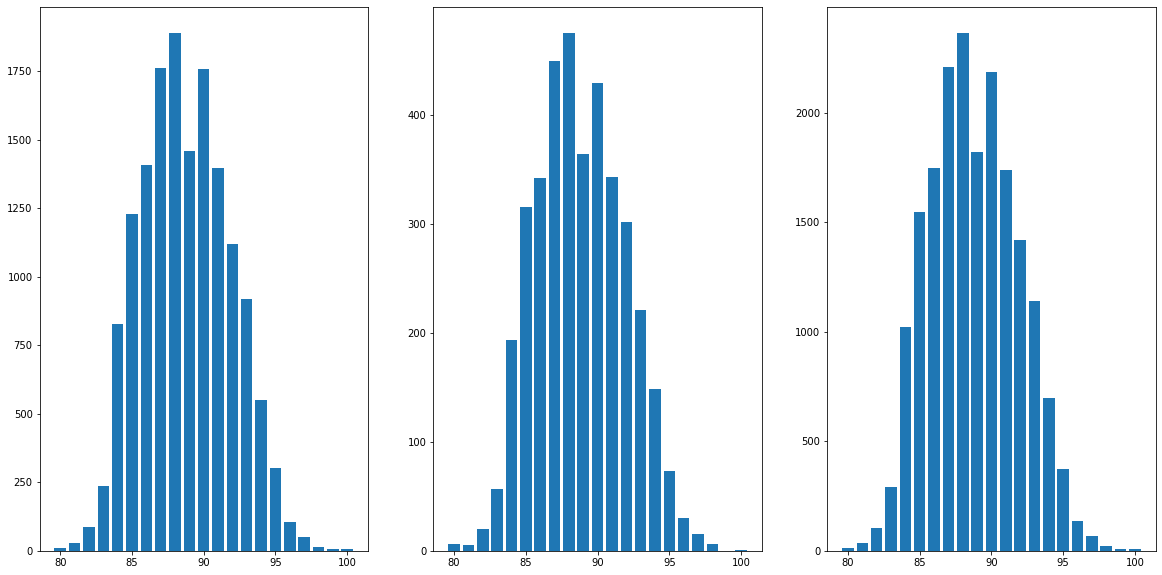

80      0.059316
81      0.197720
82      0.566796
83      1.548804
84      5.457062
85      8.113096
86      9.273051
87     11.612733
88     12.456337
89      9.622355
90     11.599552
91      9.213735
92      7.374942
93      6.063402
94      3.624860
95      1.990378
96      0.698609
97      0.336123
98      0.092269
99      0.052725
100     0.046135
Name: points, dtype: float64

In [11]:
train_labels_serie = y_train.value_counts().sort_index()
test_labels_serie = y_test.value_counts().sort_index()
init_labels_serie = df['points'].value_counts().sort_index()


plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.bar(x=train_labels_serie.index,
        height=train_labels_serie)

plt.subplot(1,3,2)
plt.bar(x=test_labels_serie.index,
        height=test_labels_serie)

plt.subplot(1,3,3)
plt.bar(x=init_labels_serie.index,
        height=init_labels_serie)

plt.show()

(y_train.value_counts().sort_index() / len(y_train)) * 100

In [12]:
(y_train.value_counts().sort_index() / len(y_train)) * 100

80      0.059316
81      0.197720
82      0.566796
83      1.548804
84      5.457062
85      8.113096
86      9.273051
87     11.612733
88     12.456337
89      9.622355
90     11.599552
91      9.213735
92      7.374942
93      6.063402
94      3.624860
95      1.990378
96      0.698609
97      0.336123
98      0.092269
99      0.052725
100     0.046135
Name: points, dtype: float64

## Pipelines

### Strategy for each column

0) Column "index" 
    => DROP
    
1) Column "Unname : 0" 
    => DROP

2) Column "country" 
    => Just "France" 
    => DROP

3) Column "description" 
    => DROP IN A FIRST TIME (NLP analysis then)

4) Column "designation"
    => Wine Name
    => DROP IN A FIRST TIME
    
5) Column "points"
    => NUMERIC/CATEGORICAL
    => TARGET / LABELS
    
6) Column "price" 
    => NUMERIC, NaN Replaced by median (25 vs 35 pour moy mais on s'affranchit des grandes valeurs)
    
7) Column "province"
    => CATEGORICAL, no Nan

8) Column "region_1" : 
    => If time : Deep Cleaning
    => Replace NaN by "unknown" (already exists in the table)

9) Column "region_2" 
    => Just Nan
    => DROP

10) Column "taster_name" : 
    => CATEGORICAL, Replace NaN by "unknown"

11) Column "taster_twitter_handle" : 
    => REDUNDANT with column "taster_name
    => DROP
    
12) Column "title" : 
    => Name of the wine
    => DROP  

13) Column "variety" (=cepage)
    => CATEGORICAL, no Nan

14) Column "winery"
    => CATEGORICAL, no Nan


In [13]:
def column_dropper(df, drop_col):
    ''' df : pandas dataframe 
        drop_col : list of columns in df to drop
        
        return : dataframe
    '''
    return df.drop(drop_col,axis=1)
    

In [14]:
def numeric_transformer(simple_imp_strat):
    ''' Dealing with numerical columns
        simple_imp_strat : strategy to apply on the simpleimputer
        
        return : pipeline with simpleimputer and standard scaler
    '''
    num_steps = [('imputer', SimpleImputer(strategy=simple_imp_strat,
                                           missing_values=np.nan)),
                 ('scaler', StandardScaler())]
    num_pipe = Pipeline(steps=num_steps)
    return num_pipe

In [15]:
def categorical_transformer(value_to_fill):
    ''' Dealing with categorical columns
        value_to_fill : value to fill on the simpleimputer (strategy = constant)
        
        return : pipeline with simpleimputer and onehotencoder
    '''
    cat_steps = [('imputer', SimpleImputer(strategy="constant",
                                           missing_values=np.nan,
                                           fill_value=value_to_fill)),
                 ('onehot', OneHotEncoder(#drop='first',
                                          handle_unknown='ignore'))]
    cat_pipe = Pipeline(steps=cat_steps)
    return cat_pipe

In [16]:
# Columns definition for pipeline use

#drop_col = ['index', 'Unnamed: 0', 'country', 'description', 'designation',
            #'region_2','taster_twitter_handle', 'title']
#target_col = ['points']

num_col = ['price']
cat_col_1 = ['province', 'variety', 'winery']
cat_col_2 = ['region_1']


In [17]:
#X_train = column_dropper(X_train, drop_col)
#X_test = column_dropper(X_test, drop_col)

pipe_num = numeric_transformer('median')
pipe_cat_1 = categorical_transformer('-')
pipe_cat_2 = categorical_transformer('unknown')

pipe_transformer = ColumnTransformer(transformers=[('num', pipe_num, num_col),
                                                   ('cat_1', pipe_cat_1, cat_col_1),
                                                   ('cat_2', pipe_cat_2, cat_col_2)
                                                  ],
                                     remainder='drop')


In [18]:
#pipe_transformer.fit(df.drop("points", axis=1))

X_train = pipe_transformer.fit_transform(X_train_init)
X_test = pipe_transformer.transform(X_test_init)

In [19]:
print(X_test.toarray().shape)
print(X_train.toarray().shape)
print(y_test.shape)
print(y_train.shape)




(3794, 4086)
(15173, 4086)
(3794,)
(15173,)


# Save Data

In [20]:
import pickle

with open ("data/X_train.pkl","wb") as f:
    pickle.dump(X_train, f)
    
with open ("data/X_test.pkl","wb") as f:
    pickle.dump(X_test, f)   
    
with open ("data/y_train.pkl","wb") as f:
    pickle.dump(y_train, f)

with open ("data/y_test.pkl","wb") as f:
    pickle.dump(y_test, f)
    
    

# Save Pipeline

In [21]:
with open ("models/data_preparation_pipe.pkl","wb") as f:
    pickle.dump(pipe_transformer, f)

# Pipeline Test / Draft

In [22]:
#valeur à tester

X_test_init = X_test_init.reset_index()
X_test_init = X_test_init.drop("index", axis=1)

def data_test(nb):
    index = sample(list(X_test_init.index), nb)
    for nombre in index:
        liste_X = list(X_test_init.iloc[nombre,:].values)
        liste_y = [int(y_test.iloc[nombre])]
        print(liste_X + liste_y)
        

In [23]:
data_test(3)


[60.0, 'Bordeaux', 'Bordeaux-style Red Blend', 'Château Giscours', 'Margaux', 94]
[16.0, 'Loire Valley', 'Sauvignon Blanc', 'Domaine des Pierrettes', 'Touraine', 88]
[nan, 'Beaujolais', 'Gamay', 'Georges Duboeuf', 'Chénas', 84]
